# Importing Packages Needed

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
from scipy.interpolate import UnivariateSpline
import glob 

# Definition of Named Tuples

In [2]:
subpulse = col.namedtuple('subpulse','phase intensity')
ind_sub = col.namedtuple('ind_sub','phase intensity width')
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 mid1 mid2 sub2, errors')
pulse_fits = col.namedtuple('pulse_fits','thorsett, powerlaw, linear')
one_fit = col.namedtuple('one_fit','params, errors, cov, chir')
pl_av = col.namedtuple('pl_av', 'frequency, phase')

# Definition of Functions

Functions needed to calculate chi squared values and find error in pulse data

In [3]:
def chsq(observed_values, expected_values, err):
    """
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [4]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [5]:
"""
Definitions of gaussian equations. 
"""
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

"""
Fitting data into the above gaussian equations. Number of gaussians is dependent on expected value and bounds.
"""
def multi_fit(x, y, error, expect, bound):
    params,cov=curve_fit(multi_gauss,x,y,expect,bounds=bound)
    fit=multi_gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-len(params))
    
    return params, cov, fit, chir

In [6]:
"""
    Creates a four gaussian fit for the full frequency scrunched data.
    Uses the peak of data to creat an expected value, attempts a fit, and if the chi squared reduced is below 1.1
    it returns the fit.
""" 

def fitting_ave_gaussians(x,y, error):   
    #Finding peak of the data
    mx=max(y)
    yl=list(y)
    mx_ind=yl.index(mx)
    mx_ph=x[mx_ind]
    
    #Attempts to use the peak of the data as an expected value, if it is in the correct range
    if mx_ph>300 and mx_ph<550:
        expect=[mx,mx_ph,10, 15,500,5,15,550,5, 25,650,10]
    elif mx_ph>550 and mx_ph<700:
        expect=[25,400,10, 15,500,5,15,550,5, mx,mx_ph,10]
    else:
        expect=[25,400,10,15,500,5,15,550,5,25,650,10]

    bound=([0,0,0,0,460,0,0,460,0,0,570,0],[np.inf,460,30,np.inf,570,30,np.inf,570,30,np.inf,np.inf,30])
    
    #Trys to create a four gaussian fit
    try:
        params, cov, fit, chir = multi_fit(x, y, error, expect, bound)
        sigma=np.sqrt(np.diag(cov))
    except Exception as e:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0
    
    #If the data has a chi squared reduced above 1.1 then don't use the pulse
    if chir>1.1:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0        
        
    return fit, params, sigma, cov, chir

In [7]:
"""
    Based off the parameters of the fitting on the frequency scrunched profile, it creates an expected value for gaussian fits.
    Detects how many peaks are above 15 intensity, and that is the number of expected gaussians.
    If the maximum peak has a signal to noise less than 3.5, don't include this pulse. 
""" 
def find_expected(ax,ay,aerror):
    #Find the gaussian fit on the frequency scrunched profile
    fit, params, sigma, cov, chir=fitting_ave_gaussians(ax,ay, aerror)
    expect=[]
    
    if fit!=[]:
        #Find the peaks of the fit
        minima,maxima,mine,maxe=find_minima_maxima_gauss(params, cov, len(ax))
        maxy=multi_gauss(maxima,*params)
        peaks=[]
        peaky=[]
        #Only include profiles where the max peak has a signal/noise greater than 3.5
        if (max(maxy)/aerror)>3.5:
            for i in range(len(maxima)):
                #Only include peaks which are greater than 15
                if maxy[i]>15:
                    expect.extend([(maxy[i]+5),maxima[i],5])
                    peaks.append(maxima[i])
                    peaky.append(maxy[i])
    if expect==[]:
        print('Pulse too noisey')
          
    return expect

In [8]:
"""
    Creates a gaussian fit for the data based on the expected value gained from the full frequency scrunched profile.
""" 
def fitting_gaussians(x,y, error, expect):   
    #Only includes frequency bands with error smaller than 30
    if error<30 and expect!=[]:
        #Attempts to use the peak of the data as an expected value, if it is in the correct range
        mx=max(y)
        yl=list(y)
        mx_ind=yl.index(mx)
        mx_ph=x[mx_ind]
        if mx_ph>300 and mx_ph<550:
            expect[0]=mx
        elif mx_ph>550 and mx_ph<700:
            expect[-3]=mx
        #Assigns the correct bounds, depending on number of gaussians
        bound=([],[])
        for i in range(0, len(expect), 3):
            bound[0].extend([0,0,0])
            bound[1].extend([np.inf,np.inf,30])
        #Attempts to create a fit for the data using the expected and bounds
        try:
            params, cov, fit, chir = multi_fit(x, y, error, expect,bound)
            sigma=np.sqrt(np.diag(cov))
        except:
            params=0
            fit=[]
            chir=5000
            sigma=0
            cov=0 
    else:
        params=0
        fit=[]
        chir=5000
        sigma=0
        cov=0   
    return fit, params, sigma, cov, chir

Finding Peak of Gaussian Fittings Function

In [9]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    Created by Keegan Smith
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [10]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian
    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [11]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function
    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
    #Find max and min errors
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [12]:
def gauss_peaksn(fit, nofreqband, freqband, cov, params,freq_low,freq_high,noise):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    #Used to convert phase bins into degrees
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err=find_minima_maxima_gauss(params, cov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    pul1=subpulse(phase=0, intensity=0)
    mi1=subpulse(phase=0, intensity=0)
    mi2=subpulse(phase=0, intensity=0)
    pul2=subpulse(phase=0, intensity=0)
    error=[0,0,0,0]
    
    #Assign the peaks to be either subpulse 1 or 2, or mid 1 or 2, also converts phase from bins to degrees
    if len(peakpos)!=0:
        for i in range(len(peakpos)):
            if peakpos[i]<455 and peakpos[i]>285 and (peakint[i]/noise)>2.5 and peakint[i]>pul1[1]:
                pul1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[0]=(err[i]*(deg_mod))
            elif peakpos[i]<520 and peakpos[i]>455 and (peakint[i]/noise)>1.5 and peakint[i]>mi1[1]:
                mi1=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[1]=(err[i]*(deg_mod))
            elif peakpos[i]<570 and peakpos[i]>520 and (peakint[i]/noise)>1.5 and peakint[i]>mi2[1]:
                mi2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[2]=(err[i]*(deg_mod))        
            elif peakpos[i]<850 and peakpos[i]>570 and (peakint[i]/noise)>2.5 and peakint[i]>pul2[1]:
                pul2=subpulse(phase=(deg_mod)*peakpos[i], intensity=peakint[i])
                error[3]=(err[i]*(deg_mod))

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low
    profile_comp = pulse_sub(frequency=freq, sub1=pul1, mid1=mi1, mid2=mi2, sub2=pul2, errors=error)

    return profile_comp

Plotting Fittings Functions

In [13]:
"""
    Used to make different plots of the fits, their components and peaks.
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot((360/1024)*x,y, lw=0.5)
    py.plot((360/1024)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[]
    y=[]
    for i in range(1,5):
        if profile_comp[i][0]!=0:
            x.append(profile_comp[i][0])
            y.append(profile_comp[i][1])

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Finding powerlaw and thorsett fits for data points

In [14]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return (x * m+c)

In [15]:
"""
    Attempts to fit a thorsett, power law and linear equation to the data. Also calculates chi squared and reduced 
"""
def three_fits(frequency_comp, phase_comp, comp_err, num): 
    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1,0.1]
        elif num==3 or num==4:
            expect=[200,0.01,0.1]
        #Create the thorsett fit
        thorsett_params,thorsett_cov=curve_fit(thorsett,frequency_comp,phase_comp, expect, sigma=comp_err, maxfev=100000)
        thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
        thorsettf = thorsett(frequency_comp, *thorsett_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,thorsettf, comp_err)
        chre=ch/(len(phase_comp)-3)

        thorsett_fit=one_fit(params=thorsett_params, errors=thorsett_fit_error, cov=thorsett_cov, chir=chre)  
    except:
        print('No thorsett for component')
        thorsett_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[100,0.1]
        elif num==3 or num==4:
            expect=[200,0.01]
        #Create the powerlaw fit
        pl_params,pl_cov=curve_fit(powerlaw,frequency_comp,phase_comp,expect, sigma=comp_err, maxfev=100000)
        pl_fit_error=np.sqrt(np.diag(pl_cov))
        powerlawf = powerlaw(frequency_comp, *pl_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,powerlawf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        pl_fit=one_fit(params=pl_params, errors=pl_fit_error, cov=pl_cov, chir=chre)
    except:
        print('No power law for component')
        pl_fit=0

    try:
        #Sets the expected values based on the subpulse number
        if num==1 or num==2:
            expect=[0.05,130]
        elif num==3 or num==4:
            expect=[0.01,230]
        #Create the linear fit
        lin_params,lin_cov=curve_fit(linear,frequency_comp,phase_comp,expect, sigma=comp_err)
        lin_fit_error=np.sqrt(np.diag(lin_cov))
        linearf = linear(np.array(frequency_comp), *lin_params)
        #Find the chi squared values
        ch=chsq_err(phase_comp,linearf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        lin_fit=one_fit(params=lin_params, errors=lin_fit_error, cov=lin_cov, chir=chre)
    except:
        print('No linear for component')
        lin_fit=0
        
    pulse_fit=pulse_fits(thorsett=thorsett_fit, powerlaw=pl_fit, linear=lin_fit)
    
    return pulse_fit

In [16]:
def find_fits(fit_spulse):
    """
    Create the fits for each subpulse 1 through to 4
    """
    sfit1=0
    sfit2=0
    sfit3=0
    sfit4=0
    
    #Find the movement of pulse across frequency for sub pulse 1, converting into graphable arrays
    p1, f1, e1=graphing_spulse(fit_spulse,1)
    #Remove outliers
    if p1!=[]:
        f1, p1, e1 = detect_outlier(f1, p1, e1,2)
        #Only include if there are 4 or more points, and if their range is no greater than 17
        if len(p1)>3 and (max(p1)-min(p1))<17:
            sfit1=three_fits(f1, p1, e1,1)
            
    #Find the movement of pulse across frequency for sub pulse 2, converting into graphable arrays
    p2, f2, e2=graphing_spulse(fit_spulse,2)
    #Remove outliers
    if p2!=[]:
        f2, p2, e2 = detect_outlier(f2, p2, e2,2)
        #Only include if there are 4 or more points, and if their range is no greater than 10
        if len(p2)>3 and (max(p2)-min(p2))<10:
            sfit2=three_fits(f2, p2, e2,2)
            
    #Find the movement of pulse across frequency for sub pulse 3, converting into graphable arrays
    p3, f3, e3=graphing_spulse(fit_spulse,3)
    #Remove outliers
    if p3!=[]:
        f3, p3, e3 = detect_outlier(f3, p3, e3,2)
        #Only include if there are 4 or more points, and if their range is no greater than 10
        if len(p3)>3 and (max(p3)-min(p3))<10:
            sfit3=three_fits(f3, p3, e3,3)

    #Find the movement of pulse across frequency for sub pulse 4, converting into graphable arrays
    p4, f4, e4=graphing_spulse(fit_spulse,4)
    #Remove outliers
    if p4!=[]:
        f4, p4, e4 = detect_outlier(f4, p4, e4, 2)
        #Only include if there are 4 or more points, and if their range is no greater than 5
        if len(p4)>3 and (max(p4)-min(p4))<5:
            sfit4=three_fits(f4, p4, e4,4)
     
    all_fits=[sfit1, sfit2, sfit3, sfit4] 
    return all_fits

Averaging all single pulse movement

In [17]:
def jacobian_slope_pl(length,x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x
    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def ddA(A, alpha, x):
        return (1/length)*x**alpha
    def ddalpha(A, alpha, x):
        return (1/length)*alpha*A*x**(alpha-1)
    J = []
    for i in range(0, len(params), 2):
        A = params[i]
        alpha = params[i+1]
        mypars = [A, alpha, x]
        J.append(ddA(*mypars))
        J.append(ddalpha(*mypars))
    J = np.asmatrix(J)
    return J

In [18]:
def find_y_err_pl(x, popt, pcov):
    """
    Finds the error in the averaged power laws point x, based on all averaged together errors.
    x=list of all frequencys. 
    popt = parameter list across all pulses. 
    pcov=covarience matrix for all pulses
    sigma_y = sqrt.J*C*J_T
    """
    #Combine multiple cov matrices into one
    cov=np.zeros((len(pcov)*2,len(pcov)*2))
    for i, c in enumerate(pcov):
        cov[i*2][i*2]=c[0][0]
        cov[i*2][i*2+1]=c[0][1]
        cov[i*2+1][i*2]=c[1][0]
        cov[i*2+1][i*2+1]=c[1][1]
    err=[]
    #Finding the error - sqrt.J*C*J_T
    for i, point in enumerate(x):
        J = jacobian_slope_pl(len(x),point, *popt)
        JC = np.matmul(J, cov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        err.append(sigma_y)
    return err
#returns a list of errors

In [19]:
"""
    Functions used to get an average value of a list, the average of a list of parameters 
    and create a continuous powerlaw - x and y arrays.
"""
def average(num_list):
    sum_num=0
    for n in num_list:
        sum_num=sum_num+n
    avg=sum_num/len(num_list)
    return avg

def average_plfits(comp_params):
    param1=[]
    param2=[]
    for i, fit in enumerate(comp_params):
        param1.append(fit[0][0])
        param2.append(fit[0][1])

    av_param1=average(param1)
    av_param2=average(param2)
    return av_param1, av_param2

def create_pl_fit(lower,upper,param1,param2):
    x=list(range(lower,upper))
    y=[]
    for freq in x:
        y.append(param1 * (freq**(param2)))
    return x,y

Extra Stuff

In [20]:
"""
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_spulse)):
            if fit_spulse[i][spulse_num][0]!=0:
                phase_comp.append(fit_spulse[i][spulse_num][0])
                frequency_comp.append(fit_spulse[i][0])
                comp_err.append(fit_spulse[i][5][spulse_num-1])

        return phase_comp, frequency_comp, comp_err    

In [21]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

# INDIVIDUAL FREQUENCY BANDS

This section is mainly used for error checking the individual frequency bands of a pulse.

## Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [22]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])
single_pulse = np.loadtxt(fname='/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse_1503961235.pazi.pdv', dtype=fulldatatype)
no_freq_bands = max(single_pulse['frequency'])+1
scrunched_pulse = np.loadtxt(fname='/home/lisasmith/sspulsar/archivefiles/s_archivefiles/F/pulse_1503961235.F.pdv', dtype=fulldatatype)

## Gaussian Fitting - Broken Down for Each Frequency

From all the frequency profiles it takes only the one frequency band. 

In [23]:
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])

#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [24]:
#Isolating a single frequency for a pulse
freqband = 9
f = single_pulse['frequency'] == freqband

x=single_pulse['phase'][f]
y=single_pulse['intensity'][f]
noise = sigmaClip(y)
error = np.nanstd(noise[1])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


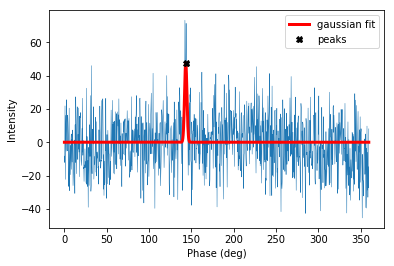

In [25]:
#Uses expected parameters and returns a fit for the frequency band
fit, params, sigma, cov, chir=fitting_gaussians(x,y,error, expect)
#If there is a fit, finds peaks where derivative is equal to zero
#Also classifys it as subpulse 1, 2, 3 or 4 depending on location
if fit!=[] and expect!=[]:
    pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500,error)
    plot_peaks(x,y, pulse_subp)
elif fit==[]:
    print('No fit')
elif expect==[]:
    print('No expect')

# INDIVIDUAL PULSE

This section is mainly used for error checking the fit across frequency for an individual pulse.

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [26]:
fit_spulse = []
#Create arrays for full frequency scrunched pulse
ax=scrunched_pulse['phase']
ay=scrunched_pulse['intensity']
noise = sigmaClip(ay)
aerror = np.nanstd(noise[1])
#Find expected gaussian parameters based off frequency scrunched profile
expect=find_expected(ax,ay,aerror)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [27]:
for i in range(no_freq_bands):
    #Creating arrays for pulse and finding frequency band noise
    freqband = i
    f = single_pulse['frequency'] == freqband
    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    #Try creating a gaussian fit, based on expected valyes from F scrunched profile
    if len(y)!=0:
        fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
    #If a fit was created find peaks and separate into subpulse categories
    if len(y)!=0 and fit!=[] and expect!=[]:
        pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error) 
        fit_spulse.append(pulse_subp)

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


## Change of Peak Position over Frequency

Used to visually show the movement of of each subpulse across frequency, this is looped later on for all pulses


The power law equation of fit for this pulse is: 	 Phase = 127.682 ν^0.020
The errors are 4.204909149834002, 0.005465728578097763
The chi squared reduced is -1.4342085975274923, and the chi squared is 3.3947484148350453



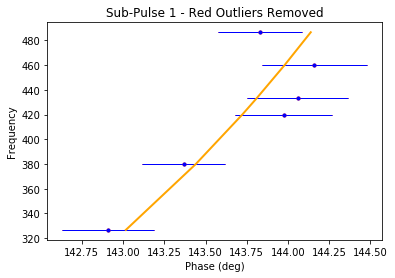

In [28]:
#Create graphable arrays for subpulse 1
p1, f1, e1=graphing_spulse(fit_spulse,1)
#Graph points and removed outliers
if p1!=[]:
    py.errorbar(p1,f1, xerr=e1, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 1 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f1, p1, e1 = detect_outlier(f1, p1, e1,2)
    #Only include if there are 4 points or more, and range is less than 17
    if len(p1)>3 and (max(p1)-min(p1))<17:
        py.errorbar(p1,f1, xerr=e1, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p1,pl_c1=curve_fit(powerlaw,f1,p1, maxfev=100000, sigma=e1)
    pl_e1=np.sqrt(np.diag(pl_c1))
    powerlaw1 = powerlaw(f1, *pl_p1)

    py.plot(powerlaw1,f1, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p1,powerlaw1, e1)
    chre=ch/len(p1)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p1[0]:.3f} \u03BD^{pl_p1[1]:.3f}')
    print(f'The errors are {pl_e1[0]}, {pl_e1[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 1')

In [29]:
#Create graphable arrays for subpulse 2
p2, f2, e2=graphing_spulse(fit_spulse,2)
#Graph points and removed outliers
if p2!=[]:
    py.errorbar(p2,f2, xerr=e2, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 2 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f2, p2, e2 = detect_outlier(f2, p2, e2,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p2)>3 and (max(p2)-min(p2))<10:
        py.errorbar(p2,f2, xerr=e2, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p2,pl_c2=curve_fit(powerlaw,f2,p2, maxfev=100000)
    pl_e2=np.sqrt(np.diag(pl_c2))
    powerlaw2 = powerlaw(f2, *pl_p2)

    py.plot(powerlaw2,f2, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p2,powerlaw2, e2)
    chre=ch/len(p2)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p2[0]:.3f} \u03BD^{pl_p2[1]:.3f}')
    print(f'The errors are {pl_e2[0]}, {pl_e2[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 2')

No power law for component 2


In [30]:
#Create graphable arrays for subpulse 3
p3, f3, e3=graphing_spulse(fit_spulse,3)
#Graph points and removed outliers
if p3!=[]:
    py.errorbar(p3,f3, xerr=e3, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 3 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f3, p3, e3 = detect_outlier(f3, p3, e3,1.5)
    #Only include if there are 4 points or more, and range is less than 10
    if len(p3)>3 and (max(p3)-min(p3))<10:
        py.errorbar(p3,f3, xerr=e3, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    pl_p3,pl_c3=curve_fit(powerlaw,f3,p3, maxfev=100000, sigma=e3)
    pl_e3=np.sqrt(np.diag(pl_c3))
    powerlaw3 = powerlaw(f3, *pl_p3)

    py.plot(powerlaw3,f3, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p3,powerlaw3, e3)
    chre=ch/len(p3)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p3[0]:.3f} \u03BD^{pl_p3[1]:.3f}')
    print(f'The errors are {pl_e3[0]}, {pl_e3[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 3')

No power law for component 3


In [31]:
#Create graphable arrays for subpulse 4
p4, f4, e4=graphing_spulse(fit_spulse,4)
#Graph points and removed outliers
if p4!=[]:
    py.errorbar(p4,f4, xerr=e4, fmt='.', color='red', lw=1, label='data')
    py.title('Sub-Pulse 4 - Red Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')
    f4, p4, e4 = detect_outlier(f4, p4, e4,2)
    #Only include if there are 4 points or more, and range is less than 5
    if len(p4)>3 and (max(p4)-min(p4))<5:
        py.errorbar(p4,f4, xerr=e4, fmt='.', color='blue', lw=1, label='data')
        py.xlabel('Phase (deg)')
        py.ylabel('Frequency')
#Create a powerlaw fit and graph
try:
    expect=[100,0.1]
    pl_p4,pl_c4=curve_fit(powerlaw,f4,p4, expect, maxfev=100000, sigma=e4)
    pl_e4=np.sqrt(np.diag(pl_c4))
    powerlaw4 = powerlaw(f4, *pl_p4)

    py.plot(powerlaw4,f4, color='orange',lw=2,label='powerlaw')
        
    ch=chsq_err(p4,powerlaw4, e4)
    chre=ch/len(p4)-2
    print(f'The power law equation of fit for this pulse is: \t Phase = {pl_p4[0]:.3f} \u03BD^{pl_p4[1]:.3f}')
    print(f'The errors are {pl_e4[0]}, {pl_e4[1]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
except:
    print('No power law for component 4')

No power law for component 4


# ALL PULSES

In [32]:
"""
Manually removing fits which visually look inaccurate, too spread, or don't match the profile.
"""
def manual_removal(pulse_num, fits):
    if pulse_num==21 or pulse_num==62 or pulse_num==486 or pulse_num==554 or pulse_num==584 or pulse_num==694 or pulse_num==752 or pulse_num==1247:
        fits[0]=0
    if pulse_num==36 or pulse_num==175 or pulse_num==251:
        fits[1]=0
    if pulse_num==100 or pulse_num==133 or pulse_num==251 or pulse_num==287 or pulse_num==290 or pulse_num==291 or pulse_num==368 or pulse_num==513 or pulse_num==1116:
        fits[2]=0
    if pulse_num==31 or pulse_num==36 or pulse_num==263 or pulse_num==368 or pulse_num==479 or pulse_num==615 or pulse_num==635 or pulse_num==718 or pulse_num==832 or pulse_num==1128 or pulse_num==1256:
        fits[3]=0
    return fits

In [33]:
#Import names of files into an array
pulse_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse*")
ave_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/F/pulse*")
#Sort the names in order
pulse_names=sorted(pulse_names)
ave_names=sorted(ave_names)

0 1503960507


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


1 1503960508


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


2 1503960509
3 1503960510
Pulse too noisey
4 1503960511
5 1503960512
Pulse too noisey
6 1503960513
Plot 1
7 1503960514
Plot 1
8 1503960515
9 1503960516
Pulse too noisey
10 1503960517
Pulse too noisey
11 1503960518
Plot 4
12 1503960519
Pulse too noisey
13 1503960520
14 1503960521
15 1503960522
16 1503960523
Plot 4
17 1503960524
18 1503960525
Pulse too noisey
19 1503960526
Plot 1
20 1503960527
Plot 1
21 1503960528


/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


22 1503960529
Plot 1
23 1503960530
24 1503960531


/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


Plot 1
25 1503960532
Pulse too noisey
26 1503960533
Pulse too noisey
27 1503960534
Pulse too noisey
28 1503960535
Pulse too noisey
29 1503960536
30 1503960537
31 1503960538
32 1503960539
Plot 4
33 1503960540
Plot 4
34 1503960541
Pulse too noisey
35 1503960542
Pulse too noisey
36 1503960543
37 1503960544
Plot 2
Plot 4
38 1503960545
Pulse too noisey
39 1503960546
Pulse too noisey
40 1503960547
Pulse too noisey
41 1503960548
Pulse too noisey
42 1503960549
Pulse too noisey
43 1503960550
Pulse too noisey
44 1503960551
Pulse too noisey
45 1503960552
Plot 1
Plot 3
46 1503960553
Pulse too noisey
47 1503960554
Pulse too noisey
48 1503960555
Pulse too noisey
49 1503960556
Pulse too noisey
50 1503960557
Plot 4
51 1503960558
Plot 4
52 1503960559
Plot 4
53 1503960560
Pulse too noisey
54 1503960561
55 1503960562
56 1503960563
Pulse too noisey
57 1503960564
Pulse too noisey
58 1503960565
59 1503960566
60 1503960567
Plot 1
61 1503960568
Pulse too noisey
62 1503960569
63 1503960570
Pulse too noisey
64 

Pulse too noisey
328 1503960835
Pulse too noisey
329 1503960836
Pulse too noisey
330 1503960837
Pulse too noisey
331 1503960838
Pulse too noisey
332 1503960839
Pulse too noisey
333 1503960840
Pulse too noisey
334 1503960841
Pulse too noisey
335 1503960842
Pulse too noisey
336 1503960843
Pulse too noisey
337 1503960844
Pulse too noisey
338 1503960845
Pulse too noisey
339 1503960846
Pulse too noisey
340 1503960847
Pulse too noisey
341 1503960848
Pulse too noisey
342 1503960849
Pulse too noisey
343 1503960850
Pulse too noisey
344 1503960851
Pulse too noisey
345 1503960852
Pulse too noisey
346 1503960853
Pulse too noisey
347 1503960854
Pulse too noisey
348 1503960855
Pulse too noisey
349 1503960856
Pulse too noisey
350 1503960857
Pulse too noisey
351 1503960858
Pulse too noisey
352 1503960859
Pulse too noisey
353 1503960860
Pulse too noisey
354 1503960861
Pulse too noisey
355 1503960862
356 1503960863
Pulse too noisey
357 1503960864
Pulse too noisey
358 1503960865
Pulse too noisey
359 1503

611 1503961118
Plot 1
612 1503961119
Pulse too noisey
613 1503961120
Pulse too noisey
614 1503961121
Pulse too noisey
615 1503961122
616 1503961123
Plot 4
617 1503961124
Plot 4
618 1503961125
Pulse too noisey
619 1503961126
Pulse too noisey
620 1503961127
621 1503961128
622 1503961129
Pulse too noisey
623 1503961130
Pulse too noisey
624 1503961131
Pulse too noisey
625 1503961132
Pulse too noisey
626 1503961133
Plot 1
627 1503961134
Plot 1
628 1503961135
Pulse too noisey
629 1503961136
Pulse too noisey
630 1503961137
631 1503961138
Pulse too noisey
632 1503961139
Pulse too noisey
633 1503961140
Pulse too noisey
634 1503961141
635 1503961142
636 1503961143
Pulse too noisey
637 1503961144
Plot 4
638 1503961145
Plot 4
639 1503961146
Pulse too noisey
640 1503961147
Pulse too noisey
641 1503961148
Pulse too noisey
642 1503961149
Pulse too noisey
643 1503961150
Pulse too noisey
644 1503961151
Pulse too noisey
645 1503961152
Plot 1
646 1503961153
Plot 1
647 1503961154
Plot 1
648 1503961155
Pul

Pulse too noisey
891 1503961398
Pulse too noisey
892 1503961399
Pulse too noisey
893 1503961400
Pulse too noisey
894 1503961401
Pulse too noisey
895 1503961402
Pulse too noisey
896 1503961403
Pulse too noisey
897 1503961404
Pulse too noisey
898 1503961405
Pulse too noisey
899 1503961406
Pulse too noisey
900 1503961407
Pulse too noisey
901 1503961408
Pulse too noisey
902 1503961409
Pulse too noisey
903 1503961410
Pulse too noisey
904 1503961411
Pulse too noisey
905 1503961412
Pulse too noisey
906 1503961413
Pulse too noisey
907 1503961414
Pulse too noisey
908 1503961415
Pulse too noisey
909 1503961416
Pulse too noisey
910 1503961417
Pulse too noisey
911 1503961418
Pulse too noisey
912 1503961419
Pulse too noisey
913 1503961420
Pulse too noisey
914 1503961421
Pulse too noisey
915 1503961422
Pulse too noisey
916 1503961423
Pulse too noisey
917 1503961424
Pulse too noisey
918 1503961425
Pulse too noisey
919 1503961426
Pulse too noisey
920 1503961427
Pulse too noisey
921 1503961428
Pulse to

Pulse too noisey
1153 1503961660
1154 1503961661
Pulse too noisey
1155 1503961662
Plot 4
1156 1503961663
Pulse too noisey
1157 1503961664
Pulse too noisey
1158 1503961665
Pulse too noisey
1159 1503961666
Pulse too noisey
1160 1503961667
Pulse too noisey
1161 1503961668
Pulse too noisey
1162 1503961669
Pulse too noisey
1163 1503961670
Pulse too noisey
1164 1503961671
Pulse too noisey
1165 1503961672
Pulse too noisey
1166 1503961673
Pulse too noisey
1167 1503961674
Pulse too noisey
1168 1503961675
Pulse too noisey
1169 1503961676
Pulse too noisey
1170 1503961677
Pulse too noisey
1171 1503961678
Pulse too noisey
1172 1503961679
Pulse too noisey
1173 1503961680
Pulse too noisey
1174 1503961681
Pulse too noisey
1175 1503961682
Pulse too noisey
1176 1503961683
Pulse too noisey
1177 1503961684
Pulse too noisey
1178 1503961685
Pulse too noisey
1179 1503961686
Pulse too noisey
1180 1503961687
Pulse too noisey
1181 1503961688
Pulse too noisey
1182 1503961689
Pulse too noisey
1183 1503961690
Puls

Pulse too noisey
1422 1503961929
Plot 4
1423 1503961930
Pulse too noisey
1424 1503961931
Pulse too noisey
1425 1503961932
Pulse too noisey
1426 1503961933
Pulse too noisey
1427 1503961934
Pulse too noisey
1428 1503961935
Pulse too noisey
1429 1503961936
Pulse too noisey
1430 1503961937
Pulse too noisey
1431 1503961938
Pulse too noisey
1432 1503961939
Pulse too noisey
1433 1503961940
Pulse too noisey
1434 1503961941
Pulse too noisey
1435 1503961942
Pulse too noisey
1436 1503961943
Pulse too noisey
1437 1503961944
Pulse too noisey
1438 1503961945
Pulse too noisey
1439 1503961946
Pulse too noisey
1440 1503961947
Pulse too noisey
1441 1503961948
1442 1503961949
Pulse too noisey
1443 1503961950
Pulse too noisey
1444 1503961951
Pulse too noisey
1445 1503961952
Pulse too noisey
1446 1503961953
Pulse too noisey
1447 1503961954
Pulse too noisey
1448 1503961955
Pulse too noisey
1449 1503961956
Pulse too noisey
1450 1503961957
Pulse too noisey
1451 1503961958
Pulse too noisey
1452 1503961959
Puls

No handles with labels found to put in legend.


Pulse too noisey


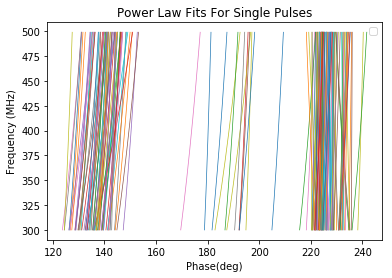

In [34]:
#Create empty arrays to be used when calculating averages of all fits
sp_params=[]
sp_cov=[]
sp_ave=[]
#Used to ensure average points are calculated at frequency intervals of 5MHz
sp_f=list(range(300, 501, 5))
for fq in sp_f:
    sp_ave.append(pl_av(frequency=fq,phase=[]))
    
#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
#py.plot((np.array(ay1)-36),ax1,lw=4,color='black', label='average component movement', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
#py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    

for a in range(1500):
    #Load in a pulse at a time
    print(a,pulse_names[a][-19:-9])
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    scrunched_pulse = np.loadtxt(fname=ave_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1

    fit_spulse = []

    #Get expected values for the gaussian fit through fitting gaussians to the average F scrunched profile
    ax=scrunched_pulse['phase']
    ay=scrunched_pulse['intensity']
    noise = sigmaClip(ay)
    aerror = np.nanstd(noise[1])
    expect=find_expected(ax,ay,aerror)
    
    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband
        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
        
        #Fit gaussians to each frequency channel
        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error,expect)
            #Find the peaks at each frequency and add to an array
            if fit!=[] and expect!=[]:
                pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500, error)
                fit_spulse.append(pulse_subp)
            

    #Find the movement of pulse across frequency and fit equations to them
    all_fits = find_fits(fit_spulse)
    #Manually remove pulses which have been visually tested
    all_fits = manual_removal(a, all_fits)

    #For all pulses with a fit, graph the powerlaw equation
    for v, fits in enumerate(all_fits):
        if fits!=0 and fits[1]!=0:
            #Create a continuous powerlaw fit from 300 to 500MHz -using fit parameters
            x1,y1=create_pl_fit(300,500,fits[1][0][0],fits[1][0][1])
            #Plot the power law fit
            py.plot(y1,x1, lw=0.7)
            print('Plot',v+1)
            #Add the parameters and covarience matrix to an ongoing array
            sp_params.extend(fits[1][0])
            sp_cov.append(fits[1][2])
            #For frequencies in the range of 300-500, stepping up by 5MHz,
            #Store the positions of the power law fits at each frequency 
            for i,fq in enumerate(sp_f):
                sp_ave[i][1].append(powerlaw(fq,fits[1][0][0],fits[1][0][1]))

#Set up the graphing axis and titles  
py.legend()
py.title('Power Law Fits For Single Pulses')
py.xlabel('Phase(deg)')
py.ylabel('Frequency (MHz)')
py.savefig('figures/spulse1500.png')

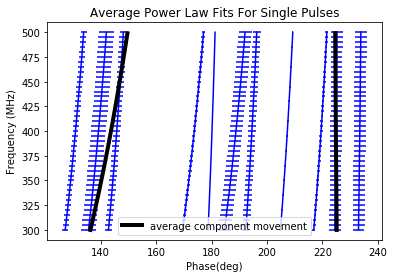

In [35]:
averages=[[] for i in range(20)]
errors=[[] for i in range(20)]
#Used to ensure average points are in phase intervals of 10 degrees
for i,n in enumerate(range(100,300,10)):
    ave_vals=[]
    cov_vals=[]
    param_vals=[]
    #Find all indicies/array positions of position values, where the position at 300MHz,
    #is in the current phase range. 
    #eg. all array entries where at 300MHz the powerlaw position is between 200-210 degrees
    indices=np.where(np.logical_and(np.array(sp_ave[0][1])>=n, np.array(sp_ave[0][1])<(n+10)))
    if len(indices[0])!=0:
        #For every value, keep track of the covarience matrix, and parameters
        for j in indices[0]:
            cov_vals.append(sp_cov[j])
            param_vals.append(sp_params[j*2])
            param_vals.append(sp_params[(j*2)+1])
        #For every frequency in steps of 5MHz, find the average of those positions - in current phase range
        for fq in range(len(sp_ave)):
            ave_vals=[sp_ave[fq][1][m] for m in np.array(indices[0])]
            averages[i].append(average(ave_vals))
        #Find the errors in all points for this phase range average, and graph the points
        errors[i]=find_y_err_pl(sp_f, param_vals, cov_vals)
        py.errorbar(averages[i],sp_f,xerr=errors[i], color='blue')

ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=4,color='black',label='average component movement', zorder=10)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=10)  

py.legend()
py.title('Average Power Law Fits For Single Pulses')
py.xlabel('Phase(deg)')
py.ylabel('Frequency (MHz)')
py.savefig('figures/spulse21500.png')
#py.axis([170,185,300,500])